## 安裝套件

In [1]:
!pip install -q requests
!pip install -q feedparser
!pip install -q lxml
!pip install -q jieba
!pip install -q wordcloud

### 下載繁體字的辭典檔

In [2]:
!wget https://github.com/fxsjy/jieba/raw/master/extra_dict/dict.txt.big -O jieba_data/dict.txt.big

--2024-01-31 15:54:56--  https://github.com/fxsjy/jieba/raw/master/extra_dict/dict.txt.big
Resolving github.com (github.com)... 20.27.177.113
Connecting to github.com (github.com)|20.27.177.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/fxsjy/jieba/master/extra_dict/dict.txt.big [following]
--2024-01-31 15:54:57--  https://raw.githubusercontent.com/fxsjy/jieba/master/extra_dict/dict.txt.big
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8583143 (8.2M) [text/plain]
Saving to: ‘jieba_data/dict.txt.big’

jieba_data/dict.txt 100%[===================>]   8.18M  7.32MB/s    in 1.1s    

2024-01-31 15:54:59 (7.32 MB/s) - ‘jieba_data/dict.txt.big’ saved [8583143/8583143]



## 解析 RSS

In [3]:
import feedparser

In [4]:
rss_url = "https://money.udn.com/rssfeed/news/1001/5588/5599?ch=money"
# udn聯合新聞網rss : https://theme.udn.com/rss/lists/1004 

In [5]:
newsFeed = feedparser.parse(rss_url)
newsFeed

{'bozo': False,
 'entries': [{'title': 'CNN：習近平向拜登保證 不干預美國總統大選',
   'title_detail': {'type': 'text/plain',
    'language': None,
    'base': 'https://money.udn.com/rssfeed/news/1001/5588/5599?ch=money',
    'value': 'CNN：習近平向拜登保證 不干預美國總統大選'},
   'links': [{'rel': 'alternate',
     'type': 'text/html',
     'href': 'https://money.udn.com/money/story/5599/7745848'}],
   'link': 'https://money.udn.com/money/story/5599/7745848',
   'published': 'Wed, 31 Jan 2024 15:45:07 +0800',
   'published_parsed': time.struct_time(tm_year=2024, tm_mon=1, tm_mday=31, tm_hour=7, tm_min=45, tm_sec=7, tm_wday=2, tm_yday=31, tm_isdst=0),
   'summary': 'CNN今天報導，中國國家主席習近平與美國總統拜登去年11月見面時，習近平向拜登表示中國不會干預2024年的美國總統大選；...',
   'summary_detail': {'type': 'text/html',
    'language': None,
    'base': 'https://money.udn.com/rssfeed/news/1001/5588/5599?ch=money',
    'value': 'CNN今天報導，中國國家主席習近平與美國總統拜登去年11月見面時，習近平向拜登表示中國不會干預2024年的美國總統大選；...'},
   'id': 'https://money.udn.com/money/story/5599/7745848',
   'guidislink':

### 查看RSS版內的所有新聞連結
查看每個 entry 的 title, url 

In [6]:
i = 1
for e in newsFeed['entries']:
    title = e['title']
    link_url = e['link']
    print("%s, %s, %s"%(i, title, link_url))
    i = i + 1

1, CNN：習近平向拜登保證 不干預美國總統大選, https://money.udn.com/money/story/5599/7745848
2, 愛知縣武豐火力發電廠傳爆炸 黑煙上竄、消防人員趕赴, https://money.udn.com/money/story/5599/7745822
3, 美媒：若中國犯台 美國是否介入取決於日本, https://money.udn.com/money/story/5599/7745763
4, 日本模擬演練 最快6天疏散12萬先島群島民眾, https://money.udn.com/money/story/5599/7745761
5, 法國會下議院通過墮胎自由入憲 恐在參院遇障礙, https://money.udn.com/money/story/5599/7745743
6, 尹錫悅憂北韓介選  下令強化自由民主價值安保, https://money.udn.com/money/story/5599/7745722
7, 投資人觀望Fed決策 日股收高, https://money.udn.com/money/story/5599/7745699
8, 談判破局！環球音樂將從TikTok撤下歌曲 聽不見泰勒絲等人的音樂, https://money.udn.com/money/story/5599/7745675
9, 搏命報導以哈衝突 加薩記者打1場全球沒看到的仗, https://money.udn.com/money/story/5599/7745666
10, 美國去年勞工離職者減少 有利抑制通膨 不利薪資上升, https://money.udn.com/money/story/5599/7745636
11, IMF上調全球經濟成長預測 稱通膨減緩比預期快, https://money.udn.com/money/story/5599/7745632
12, 巴基斯坦前總理才因洩密被判10年！ 又因貪汙罪遭判14年, https://money.udn.com/money/story/5599/7745552
13, 三星半導體Q1展望：記憶體轉虧為盈  晶圓代工無起色, https://money.udn.com/money/story/5599/7745548
14, IMF：亞洲今年稍後

## 將文章做斷詞

### 載入 library

In [7]:
import requests
from lxml import etree
from io import StringIO
import jieba
import pandas as pd
import time
import random

### 使用繁體辭典

In [8]:
# 指定辭典檔 (*辭庫 -> 分詞、詞性標註與依存)
jieba.set_dictionary('jieba_data/dict.txt.big')
# 添加自訂的字典檔 jieba.add_word()

### 開始取得文章

#### 設定 request header

In [9]:
# 設定 request header
user_agent = "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/63.0.3239.132 Safari/537.36"
my_headers = {
    'User-Agent': user_agent,
    "accept": "text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8",
    "accept-Language": "zh-TW,zh;q=0.9,en-US;q=0.8,en;q=0.7",
    "accept-encoding": "gzip, deflate, br",
    "Connection": "keep-alive",
    "cache-control": "no-cache",
    "Accept-Charset": "UTF8,utf-8;q=0.7,*;q=0.7"
}

#### 先爬文

In [10]:
# 爬文 每個文章連結
all_article_text = '' 

for e in newsFeed['entries']:
    url = e['link']

    r = requests.get(url, headers = my_headers)
    if r.status_code == 200:
        
        parse_tree = etree.parse(StringIO(r.text), etree.HTMLParser()) # XML解析 動態網頁
        article_elements = parse_tree.xpath('//*[@id="article_body"]//p') # 抓取特定標籤連結
        
        for a_part in article_elements:
            if type(a_part.text) is str:
                all_article_text += a_part.text.strip()

        # 間隔爬網頁的時間，模擬人類爬網
        sleep_time = random.randint(3,10)
        print("sleep time: %s sec"%(sleep_time))
        time.sleep(sleep_time)


sleep time: 6 sec
sleep time: 9 sec
sleep time: 8 sec
sleep time: 5 sec
sleep time: 9 sec
sleep time: 9 sec
sleep time: 10 sec
sleep time: 9 sec
sleep time: 5 sec
sleep time: 8 sec
sleep time: 6 sec
sleep time: 6 sec
sleep time: 3 sec
sleep time: 9 sec
sleep time: 6 sec
sleep time: 8 sec
sleep time: 6 sec
sleep time: 8 sec
sleep time: 4 sec
sleep time: 4 sec


### 斷詞處理

In [11]:
# 將爬好的內容 做分詞
seg_words_list = jieba.lcut(all_article_text)

# 準備 stop word (用換行符號"\n" 做為切割依據 ， 存為list型態) 
with open(file='jieba_data/stop_words.txt', mode='r', encoding='utf-8') as file:
    stop_words = file.read().split('\n')

# 去除Stop_Words 
seg_stop_words_list = []
for term in seg_words_list:
    if term not in stop_words:
        seg_stop_words_list.append(term)        
        

print(seg_stop_words_list)
seg_df = pd.DataFrame(seg_stop_words_list, columns=['seg_word'])
print(seg_df)

Building prefix dict from /home/jovyan/work/Text_wordcloud/jieba_data/dict.txt.big ...
Dumping model to file cache /tmp/jieba.u240ff8c1e70462be159af457c3f6d652.cache
Loading model cost 2.150 seconds.
Prefix dict has been built successfully.


['CNN', '今天', '報導', '中國', '國家', '主席', '習近平', '美國', '總統', '拜登', '去年', '11', '月', '見面', '時', '習近平', '向', '拜登', '表示', '中國', '不會', '干預', '2024', '年', '美國', '總統大選', '中國', '外交部長', '王毅', '上周末', '也', '向', '美國', '重申', '此項', '保證', '美國有線電視新聞網', 'CNN', '引述', '兩名', '知情', '人士', '報導', '習近平', '拜登', '加州', '曾', '有', '一次', '未', '被', '報導', '意見', '交換', '這是', '一場', '長達', '數', '小時', '重要', '會議', '期間', '進行', '會議', '旨在', '減緩', '兩大', '強權', '之間', '升高', '軍事', '經濟', '緊張', '關係', '根據', '其中', '一名', '消息人士', '指出', '拜登', '提出', '干預', '大選', '議題', '不過', '兩人', '意見', '交換', '很', '簡短', '美國', '國家', '安全', '顧問', '蘇利文', 'Jake', 'Sullivan', '上周末', '於', '泰國', '曼谷', '舉行', '會議', '中', '再次', '向', '中國', '外交部長', '王毅', '提出', '這個', '議題', '這名', '消息人士', '說', '如同', '習近平', '幾個', '月', '前', '拜登', '提出', '保證', '王毅', '蘇利文', '答覆', '也', '相同', '那', '就是', '北京', '不會', '介入', '今年', '秋天', '舉行', '美國', '大選', '知情', '人士', '說', '中國', '可能', '干預', '影響', '美國', '選舉', '這個', '議題', '近幾個月', '兩國', '高層', '級', '會談', '中', '一再', '被', '提起', '這些', '討論', '代表', '美中關係', '令人擔憂', '因

## 繪圖

### 載入繪圖相關的 library

In [12]:
import matplotlib
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [13]:
print( matplotlib.matplotlib_fname() ) # 顯示 matplotlib 路徑
!ls fonts/*.ttf # 顯示字型列表

/opt/conda/lib/python3.11/site-packages/matplotlib/mpl-data/matplotlibrc
fonts/SimHei.ttf  fonts/TaipeiSansTCBeta-Regular.ttf


In [14]:
!ls /opt/conda/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf 
# 顯示ttf 列表

cmb10.ttf			LICENSE_DEJAVU
cmex10.ttf			LICENSE_STIX
cmmi10.ttf			SimHei.ttf
cmr10.ttf			STIXGeneralBolIta.ttf
cmss10.ttf			STIXGeneralBol.ttf
cmsy10.ttf			STIXGeneralItalic.ttf
cmtt10.ttf			STIXGeneral.ttf
DejaVuSans-BoldOblique.ttf	STIXNonUniBolIta.ttf
DejaVuSans-Bold.ttf		STIXNonUniBol.ttf
DejaVuSansDisplay.ttf		STIXNonUniIta.ttf
DejaVuSansMono-BoldOblique.ttf	STIXNonUni.ttf
DejaVuSansMono-Bold.ttf		STIXSizFiveSymReg.ttf
DejaVuSansMono-Oblique.ttf	STIXSizFourSymBol.ttf
DejaVuSansMono.ttf		STIXSizFourSymReg.ttf
DejaVuSans-Oblique.ttf		STIXSizOneSymBol.ttf
DejaVuSans.ttf			STIXSizOneSymReg.ttf
DejaVuSerif-BoldItalic.ttf	STIXSizThreeSymBol.ttf
DejaVuSerif-Bold.ttf		STIXSizThreeSymReg.ttf
DejaVuSerifDisplay.ttf		STIXSizTwoSymBol.ttf
DejaVuSerif-Italic.ttf		STIXSizTwoSymReg.ttf
DejaVuSerif.ttf			TaipeiSansTCBeta-Regular.ttf


In [15]:
!cp fonts/*.ttf /opt/conda/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf 
# 將中文字型檔案放到字型收容的路徑
!ls /opt/conda/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf
# 顯示ttf 列表 

cmb10.ttf			LICENSE_DEJAVU
cmex10.ttf			LICENSE_STIX
cmmi10.ttf			SimHei.ttf
cmr10.ttf			STIXGeneralBolIta.ttf
cmss10.ttf			STIXGeneralBol.ttf
cmsy10.ttf			STIXGeneralItalic.ttf
cmtt10.ttf			STIXGeneral.ttf
DejaVuSans-BoldOblique.ttf	STIXNonUniBolIta.ttf
DejaVuSans-Bold.ttf		STIXNonUniBol.ttf
DejaVuSansDisplay.ttf		STIXNonUniIta.ttf
DejaVuSansMono-BoldOblique.ttf	STIXNonUni.ttf
DejaVuSansMono-Bold.ttf		STIXSizFiveSymReg.ttf
DejaVuSansMono-Oblique.ttf	STIXSizFourSymBol.ttf
DejaVuSansMono.ttf		STIXSizFourSymReg.ttf
DejaVuSans-Oblique.ttf		STIXSizOneSymBol.ttf
DejaVuSans.ttf			STIXSizOneSymReg.ttf
DejaVuSerif-BoldItalic.ttf	STIXSizThreeSymBol.ttf
DejaVuSerif-Bold.ttf		STIXSizThreeSymReg.ttf
DejaVuSerifDisplay.ttf		STIXSizTwoSymBol.ttf
DejaVuSerif-Italic.ttf		STIXSizTwoSymReg.ttf
DejaVuSerif.ttf			TaipeiSansTCBeta-Regular.ttf


### 繪製文字雲 ( wordcloud.generate )

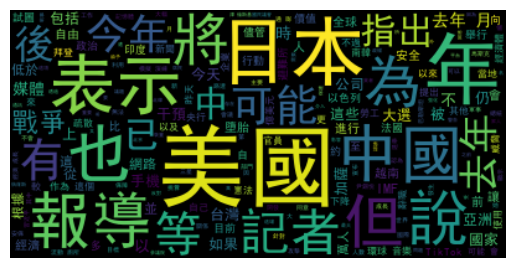

In [16]:
# wordcloud.generate 參數是吃文字內容，以空白為文字區隔
seg_words = ' '.join(seg_stop_words_list) 

#不同字型
wordcloud = WordCloud(font_path='fonts/SimHei.ttf').generate(seg_words)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# seg_words

### 繪製文字雲 ( wordcloud.generate_from_frequencies )

In [17]:
# https://docs.python.org/zh-tw/3/library/collections.html
from collections import Counter
seg_stop_counter = Counter(seg_stop_words_list)
seg_stop_counter

Counter({'美國': 60,
         '年': 46,
         '日本': 42,
         '中國': 38,
         '去年': 35,
         '表示': 33,
         '報導': 32,
         '月': 32,
         '也': 30,
         '說': 28,
         '但': 28,
         '可能': 27,
         '為': 25,
         '將': 25,
         '記者': 24,
         '等': 22,
         '有': 21,
         '經濟': 21,
         '指出': 21,
         '今年': 19,
         '後': 18,
         '中': 17,
         '已': 17,
         '戰爭': 17,
         '會': 16,
         '台灣': 15,
         '不': 14,
         '全球': 14,
         '時': 13,
         '媒體': 13,
         '以': 13,
         '1': 13,
         '10': 13,
         '低於': 13,
         '成長': 13,
         '今天': 12,
         '國家': 12,
         '被': 12,
         '這些': 12,
         '仍': 12,
         '音樂': 12,
         '加薩': 12,
         'IMF': 12,
         '干預': 11,
         '大選': 11,
         '如果': 11,
         '包括': 11,
         '政治': 11,
         '上': 11,
         '疏散': 11,
         '公司': 11,
         '手機': 11,
         '事業': 11,
         '亞洲

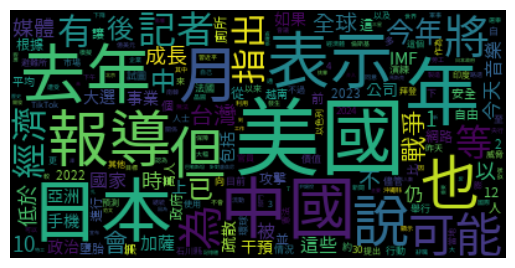

In [18]:
#有處理stop words
wordcloud = WordCloud(font_path='fonts/TaipeiSansTCBeta-Regular.ttf').generate_from_frequencies(seg_stop_counter)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig("result.png")
plt.show()
plt.close()